In [1]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Load the experiments
input_path = "temp/experiments/experiment_2020_8_25.p"
output_path = os.path.dirname(input_path)
experiments = pickle.load( open( input_path, "rb" ) )
experiments

[Rotty_Bamber_2019_high_95__5_R. Active 2020/08/25, 15:30:45,
 Rotty_SROCC_2019_RCP26_17__5_R. Active 2020/08/25, 15:30:46,
 Rotty_SROCC_2019_RCP85_50__5_R. Active 2020/08/25, 15:30:46,
 Rotty_SROCC_2019_RCP85_83__5_R. Active 2020/08/25, 15:30:46]

In [3]:
def create_df(experiment): #Create dfs from the outcomes of interest
    Model = experiment.Model
    SurgeLevel = experiment.SurgeLevel
    years = SurgeLevel.years #serve as indices for the df
    
    df = pd.DataFrame(index=years)
    for RA in Model.allResidentialArea:
        df["{}_house_price_obj".format(RA.name)] = RA.house_price_t_objective
        df["{}_house_price_subj".format(RA.name)] = RA.house_price_t_subjective 
    return df

def examine_series(series,window=4,lag=1,domain='All'):
    """Create statistics for Panda Series, used for tipping point analysis
    
    Rolling window: result is set to the right edge of the window
    
    if Cut = true: don't show rows containing al NaNs
    """
    df = pd.DataFrame(index=series.index,data=series)

    #Calculate derivates of raw time series
    df["{}".format("First order derivative (dM/dt)")] = series.to_frame().diff()
    df["{}".format("Second order derivative (d2M/dt2)")] = series.to_frame().diff().diff()
    #df["{} __ {}".format(series.name,"Autocorrelation lag {}".format(lag))] = series.autocorr(lag=lag)
    
    #Calculate statistics using a rolling window
    rolling = series.rolling(window=window)
    df["{}".format("Window mean")] = rolling.mean()
    df["{}".format("Window variance")] = rolling.var()
    #df["{} __ {}".format(series.name,"Window rolling correlation")] = rolling.apply(lambda x: x.autocorr(), raw=False)
    
    if not domain == 'All':
        df = df.loc[domain[0]:domain[1]]
    return df

def plot_statistics(statistics,figsize=(20,10),save=False,exp_name=None):
    fig,ax = plt.subplots(nrows=len(statistics.columns),ncols=1,figsize=figsize,sharex=True)
    for i, col in enumerate(list(statistics.columns)):
        statistics[col].plot(ax=ax[i],title=col)
    fig.suptitle('{}'.format(statistics.columns[0]))
    if save:
        fig.savefig(os.path.join(output_path,"{}_{}_statistics.png".format(exp_name,statistics.columns[0],dpi=150)))
        
def plot_both(statistics,candidates,figsize=(20,10),save=False,exp_name=None):
    nrows = len(statistics.columns)+1
    fig,ax = plt.subplots(nrows=nrows,ncols=1,figsize=figsize,sharex=True)
    for i, col in enumerate(list(statistics.columns)):
        statistics[col].plot(ax=ax[i],title=col)
    fig.suptitle('{}'.format(statistics.columns[0]))
    candidates.plot(ax=ax[nrows-1],title='SETP candidates by criterion',style='o')
    if save:
        fig.savefig(os.path.join(output_path,"{}_{}_statistics.png".format(exp_name,statistics.columns[0]),dpi=150,bbox_inches='tight'))
        
def select_candidates(statistics,plot=False,c1=0.2e10,c2=10e3,c3=10,window=5,margin=2):
    """
    Select tipping point candidates based on three criteria
    
    Arguments:
        *statistics* (DataFrame) : output of examine_series
        *plot* (Boolean) : plot results?
        *c1* (float) : absolute valued threshold for variance: detect stable states
        *c2* (float) : absolute change in change of metric: detect rapid change
        *c3* (float) : percentage of change between states: substantially different states
        
    Returns:
        *df* (DataFrame) : indicating in which years the criteria are met
    
    """
    ind = statistics.index
    df = pd.DataFrame(index=ind)
    
    #Criterion 1: check if variance is above threshold to detect stable states
    c1 = 0.2e10 #absolute value of variance
    df["unstable states"] = pd.Series(index=ind,data=[1]*len(ind))[statistics["Window variance"] > c1]
    
    #Criterion 2: check for rapid change
    #c2 = 5 #percentage of change per timestep considered 'rapid'
    c2 = 10e3 # absolute house-price change per timestep considered 'rapid'
    df["rapid change"] = pd.Series(index=ind,data=[2]*len(ind))[(statistics["First order derivative (dM/dt)"] < -c2)]
    c2met = list(df[df["rapid change"].notnull()].index) #list of years in which c2 is met
    
    #Criterion 3: check if states on both sides of threshold are different
    c3 = 10 #percentage of change that states before and after should be different
    c3met = []
    for y in c2met:
        avg_b,avg_a = average_before_after(statistics.iloc[:,0],y,window=window,margin=margin)
        perc = 100*(avg_a-avg_b)/avg_a
        if (perc < -1*c3) or (perc > c3) :
            c3met.append(y)
    df["substantial different states"] = pd.Series(index=c3met,data=[3]*len(c3met))
    
    return df
    
def average_before_after(data,year,window=5,margin=2):
    before = data.loc[year-margin-window:year-margin].mean()
    after = data.loc[year+margin:year+margin+window].mean()
    return(before,after)

SyntaxError: unmatched ')' (<ipython-input-3-b4c0bf28bfea>, line 52)

Rotty_Bamber_2019_high_95__5_R. Active 2020/08/25, 15:30:45
Area_A_house_price_obj


<ipython-input-34-f6ba1bf3fd62>:87: RuntimeWarning: divide by zero encountered in double_scalars
  perc = 100*(avg_a-avg_b)/avg_a


Area_A_house_price_subj


<ipython-input-34-f6ba1bf3fd62>:87: RuntimeWarning: divide by zero encountered in double_scalars
  perc = 100*(avg_a-avg_b)/avg_a


Area_B_house_price_obj


<ipython-input-34-f6ba1bf3fd62>:90: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df["substantial different states"] = pd.Series(index=c3met,data=[3]*len(c3met))


Area_B_house_price_subj
Rotty_SROCC_2019_RCP26_17__5_R. Active 2020/08/25, 15:30:46
Area_A_house_price_obj


<ipython-input-34-f6ba1bf3fd62>:90: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df["substantial different states"] = pd.Series(index=c3met,data=[3]*len(c3met))


Area_A_house_price_subj
Area_B_house_price_obj


<ipython-input-34-f6ba1bf3fd62>:90: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df["substantial different states"] = pd.Series(index=c3met,data=[3]*len(c3met))


Area_B_house_price_subj


<ipython-input-34-f6ba1bf3fd62>:90: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df["substantial different states"] = pd.Series(index=c3met,data=[3]*len(c3met))


Rotty_SROCC_2019_RCP85_50__5_R. Active 2020/08/25, 15:30:46
Area_A_house_price_obj


<ipython-input-34-f6ba1bf3fd62>:87: RuntimeWarning: divide by zero encountered in double_scalars
  perc = 100*(avg_a-avg_b)/avg_a


Area_A_house_price_subj


<ipython-input-34-f6ba1bf3fd62>:87: RuntimeWarning: divide by zero encountered in double_scalars
  perc = 100*(avg_a-avg_b)/avg_a


Area_B_house_price_obj


<ipython-input-34-f6ba1bf3fd62>:90: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df["substantial different states"] = pd.Series(index=c3met,data=[3]*len(c3met))
C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\urban-SETP\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
<ipython-input-34-f6ba1bf3fd62>:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam

Area_B_house_price_subj


<ipython-input-34-f6ba1bf3fd62>:90: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df["substantial different states"] = pd.Series(index=c3met,data=[3]*len(c3met))
C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\urban-SETP\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
<ipython-input-34-f6ba1bf3fd62>:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam

Rotty_SROCC_2019_RCP85_83__5_R. Active 2020/08/25, 15:30:46
Area_A_house_price_obj


<ipython-input-34-f6ba1bf3fd62>:87: RuntimeWarning: divide by zero encountered in double_scalars
  perc = 100*(avg_a-avg_b)/avg_a
C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\urban-SETP\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
<ipython-input-34-f6ba1bf3fd62>:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(nrows=nrows,ncols=1,figsize=figsize,sharex=True)


Area_A_house_price_subj


<ipython-input-34-f6ba1bf3fd62>:87: RuntimeWarning: divide by zero encountered in double_scalars
  perc = 100*(avg_a-avg_b)/avg_a
C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\urban-SETP\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
<ipython-input-34-f6ba1bf3fd62>:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(nrows=nrows,ncols=1,figsize=figsize,sharex=True)


Area_B_house_price_obj


<ipython-input-34-f6ba1bf3fd62>:90: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df["substantial different states"] = pd.Series(index=c3met,data=[3]*len(c3met))
C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\urban-SETP\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
<ipython-input-34-f6ba1bf3fd62>:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam

Area_B_house_price_subj


<ipython-input-34-f6ba1bf3fd62>:90: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df["substantial different states"] = pd.Series(index=c3met,data=[3]*len(c3met))
C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\urban-SETP\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
<ipython-input-34-f6ba1bf3fd62>:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam

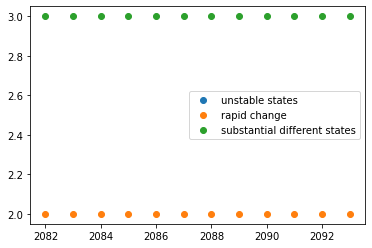

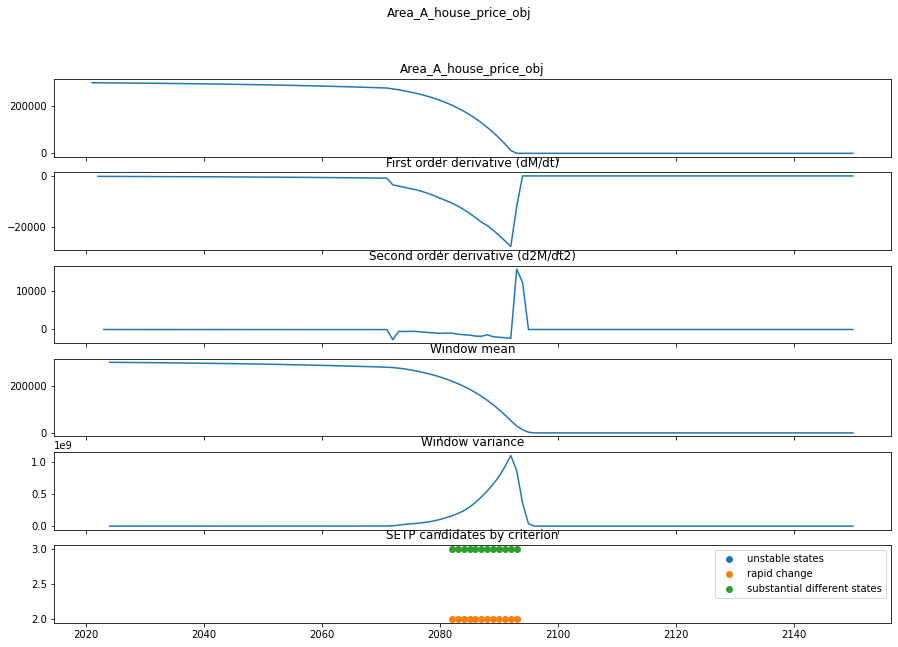

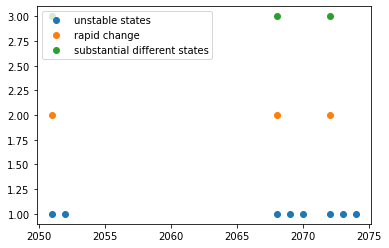

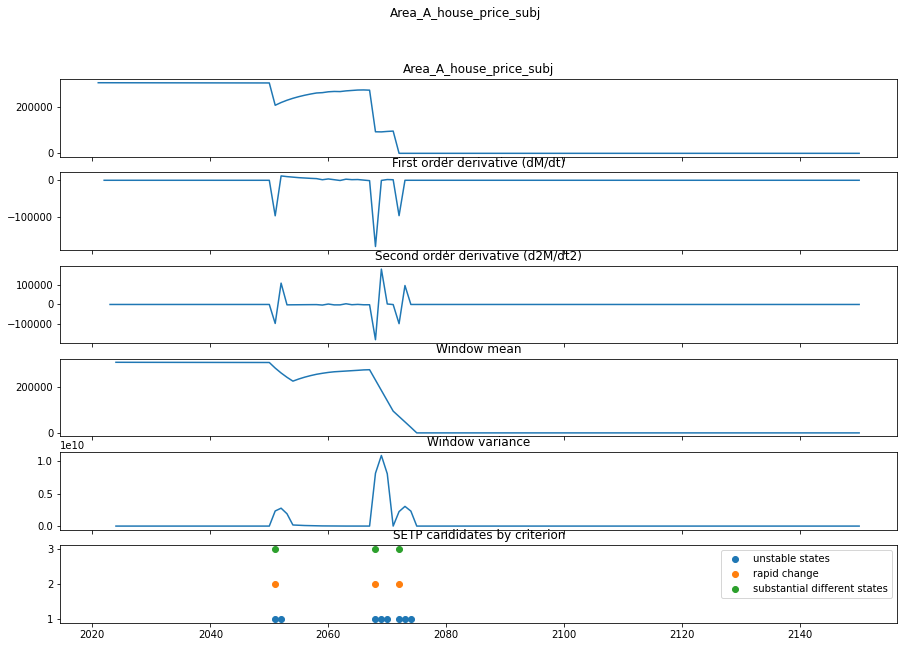

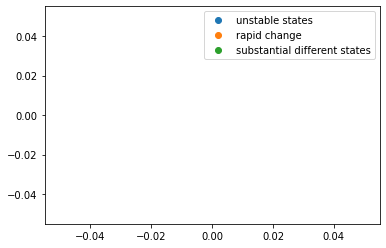

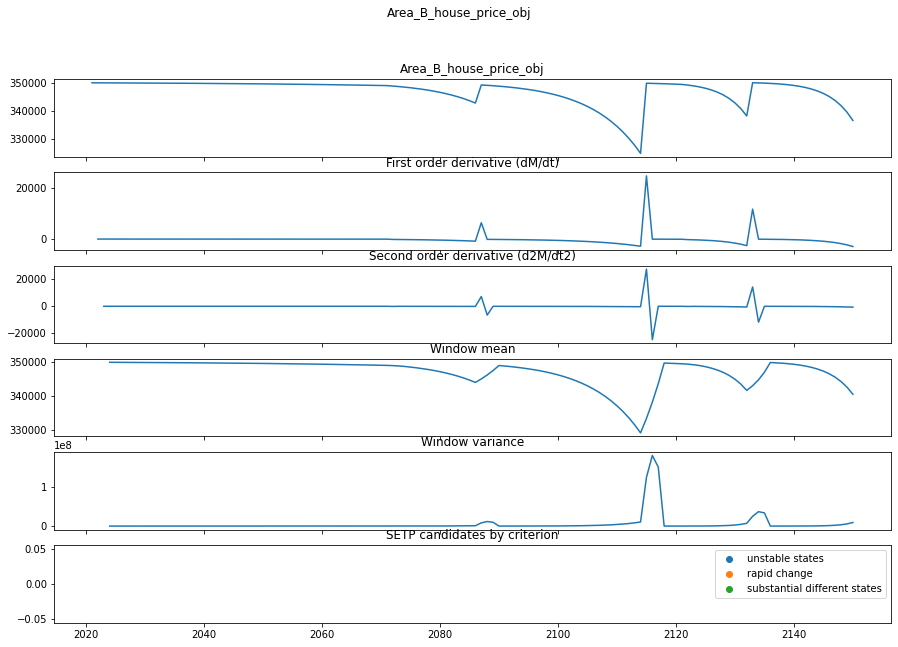

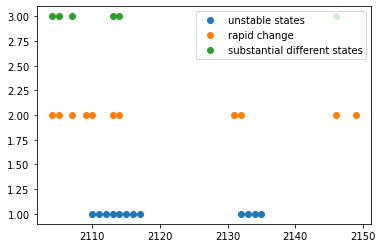

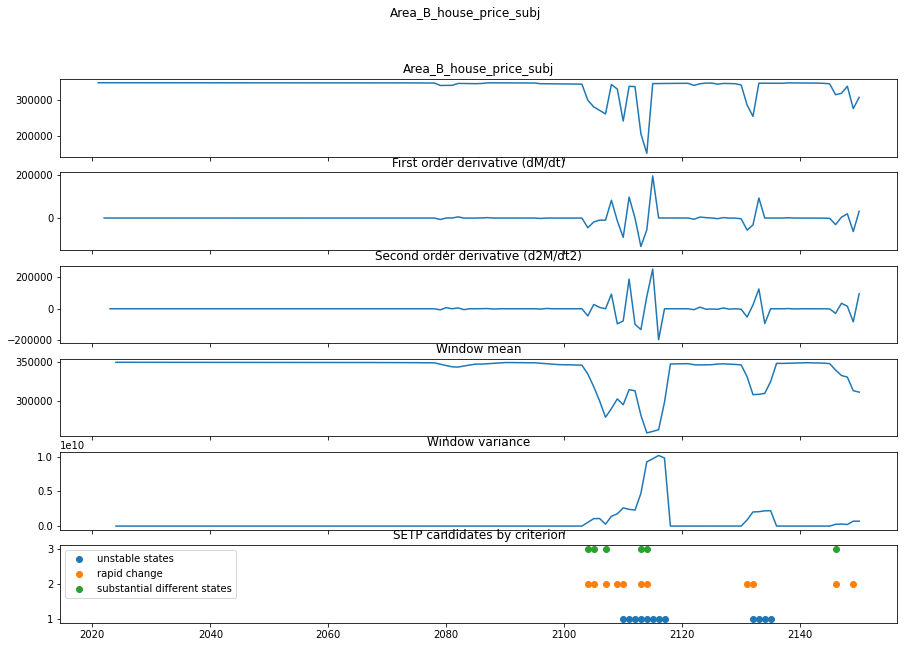

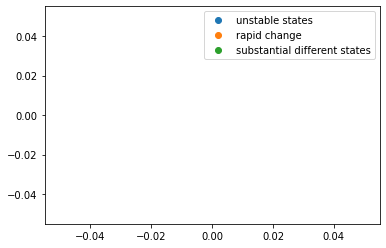

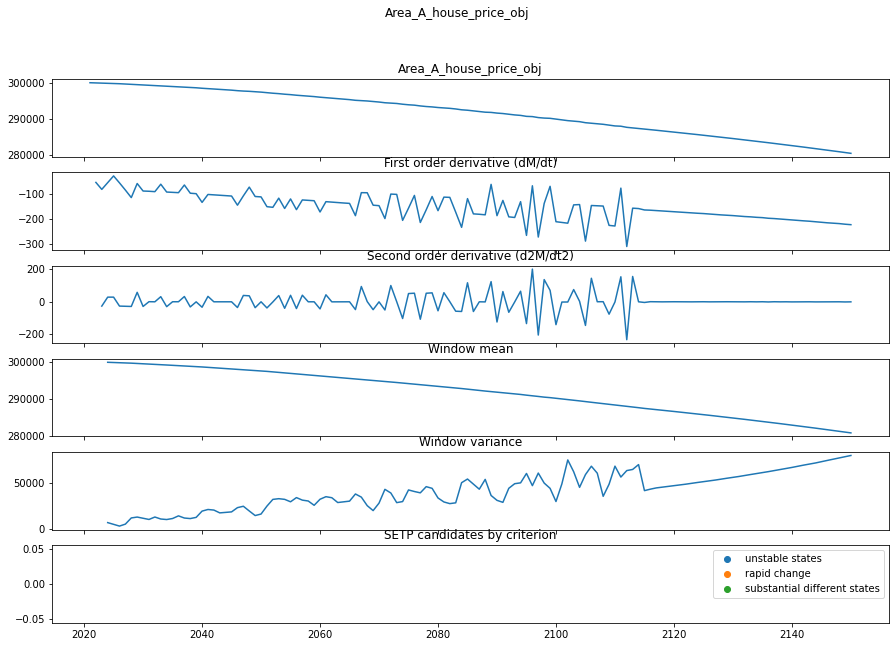

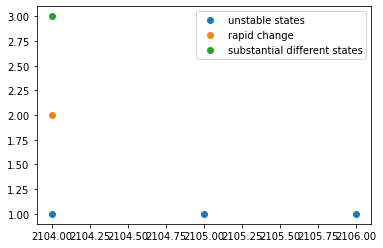

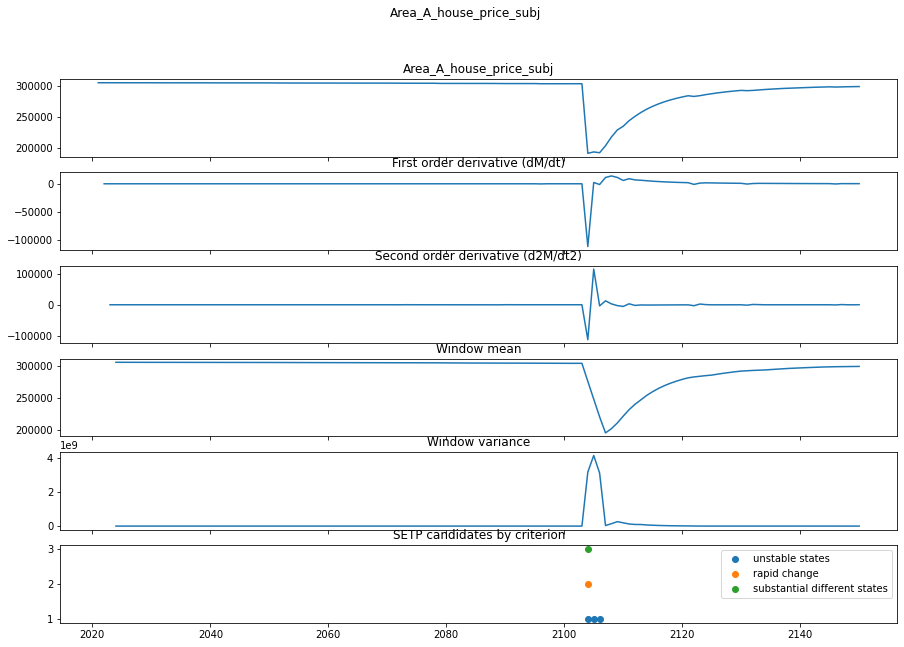

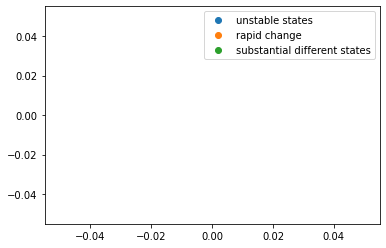

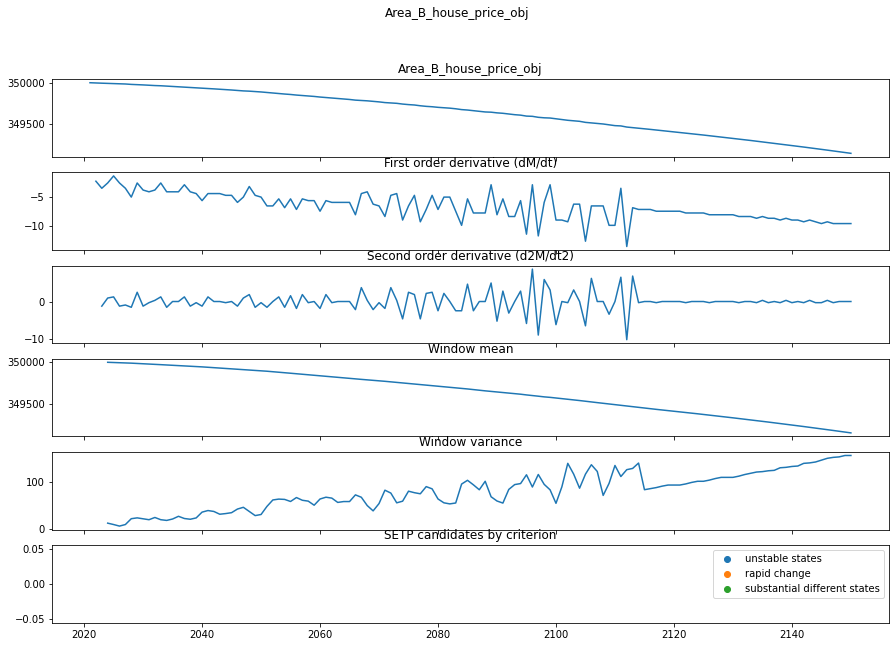

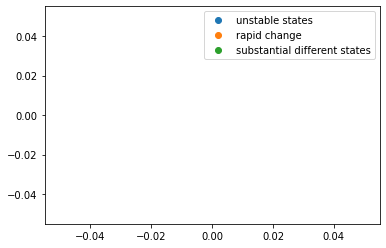

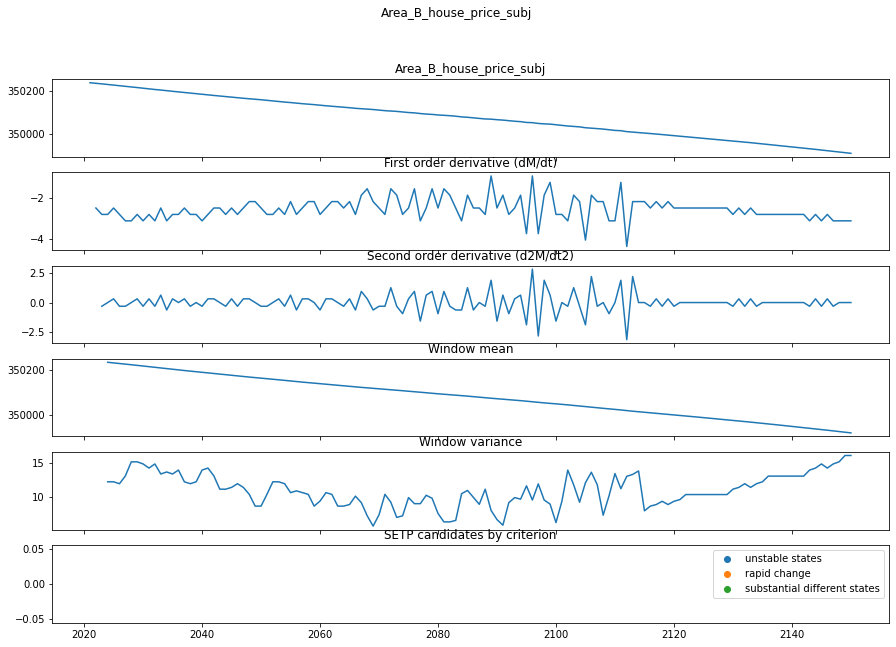

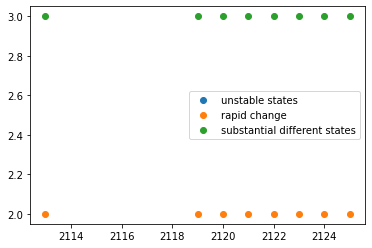

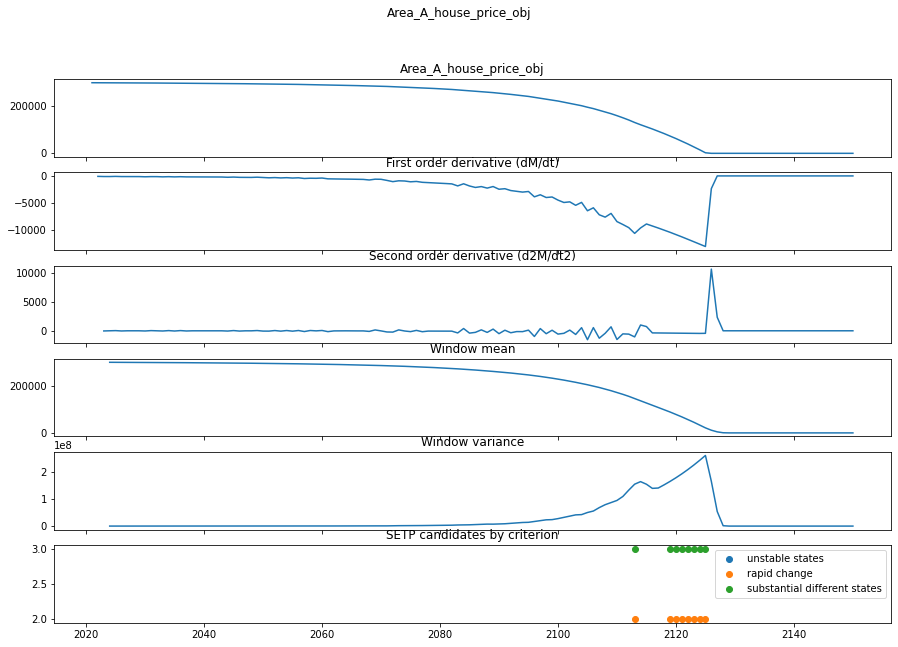

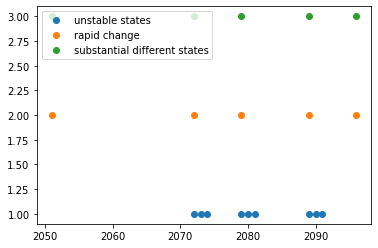

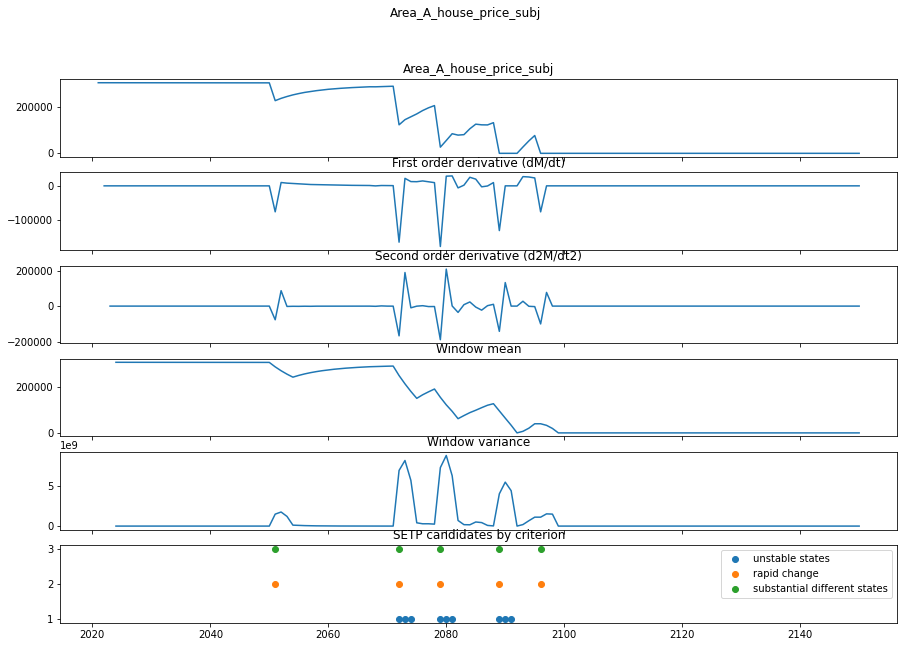

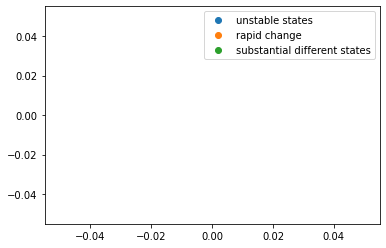

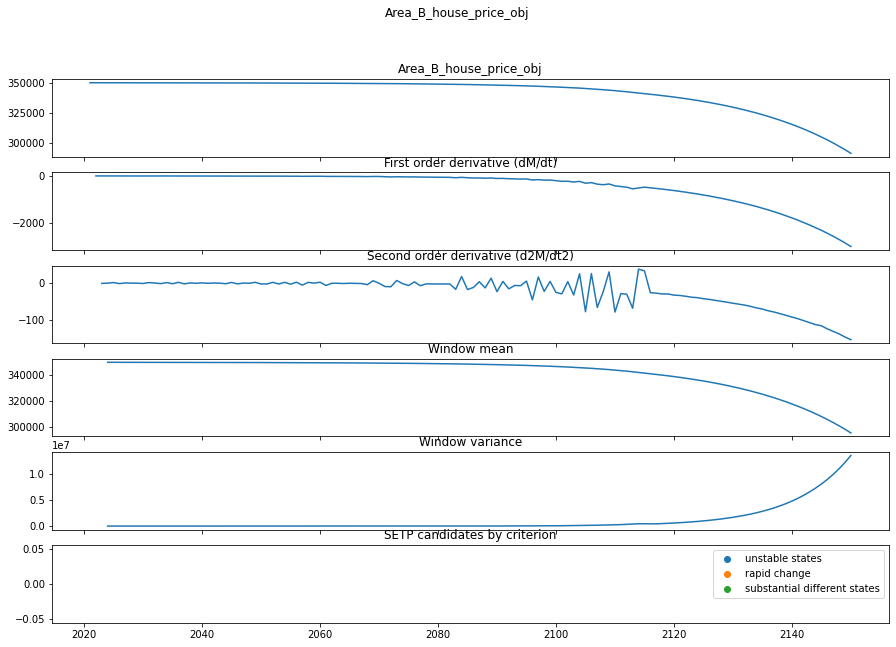

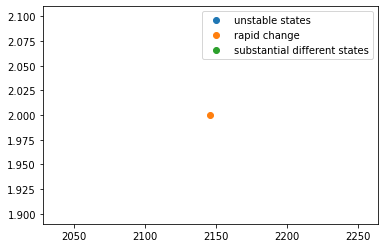

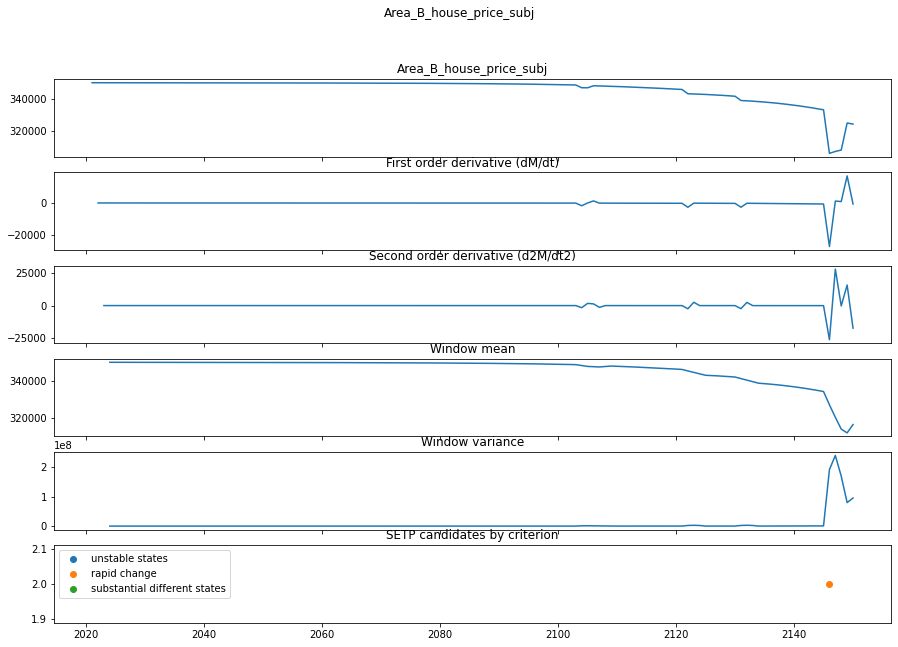

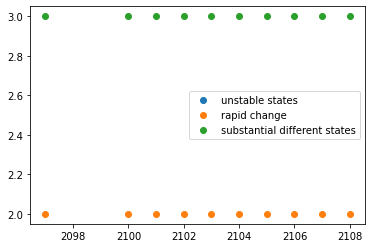

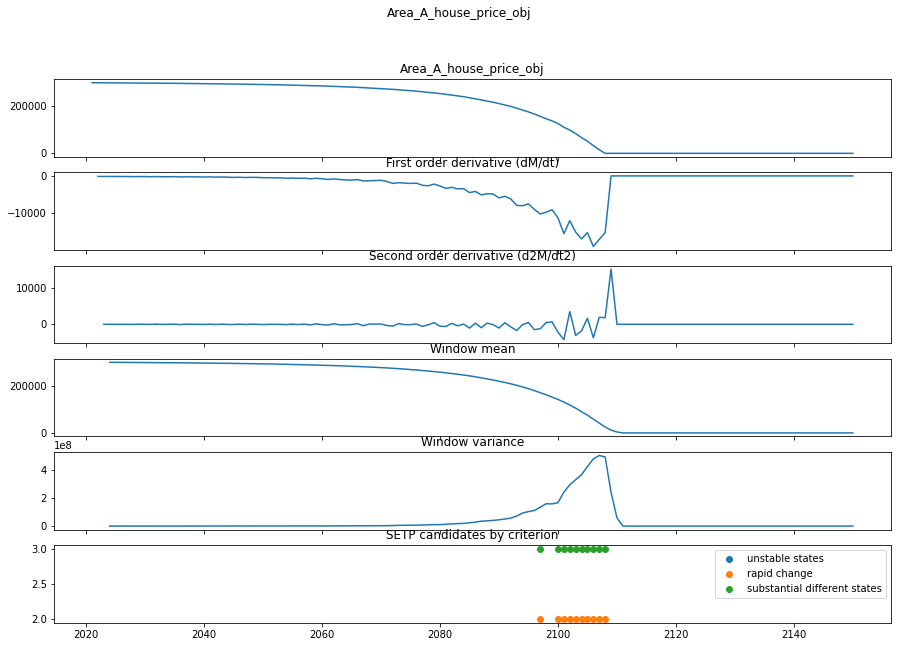

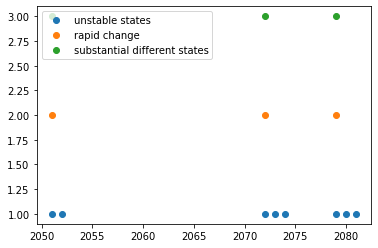

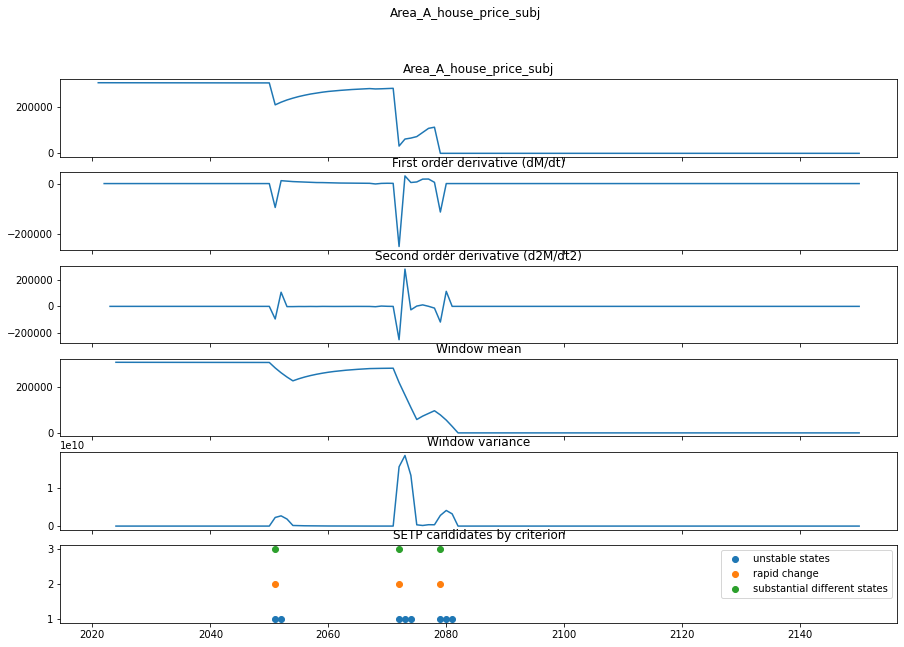

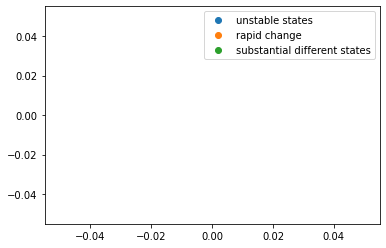

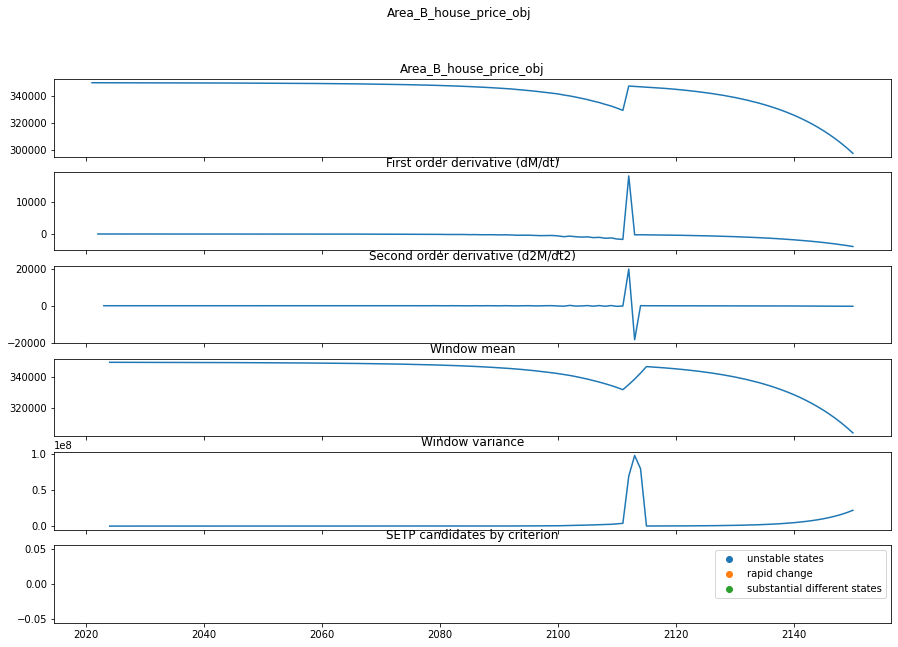

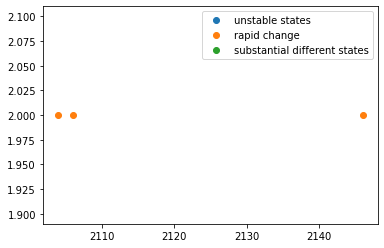

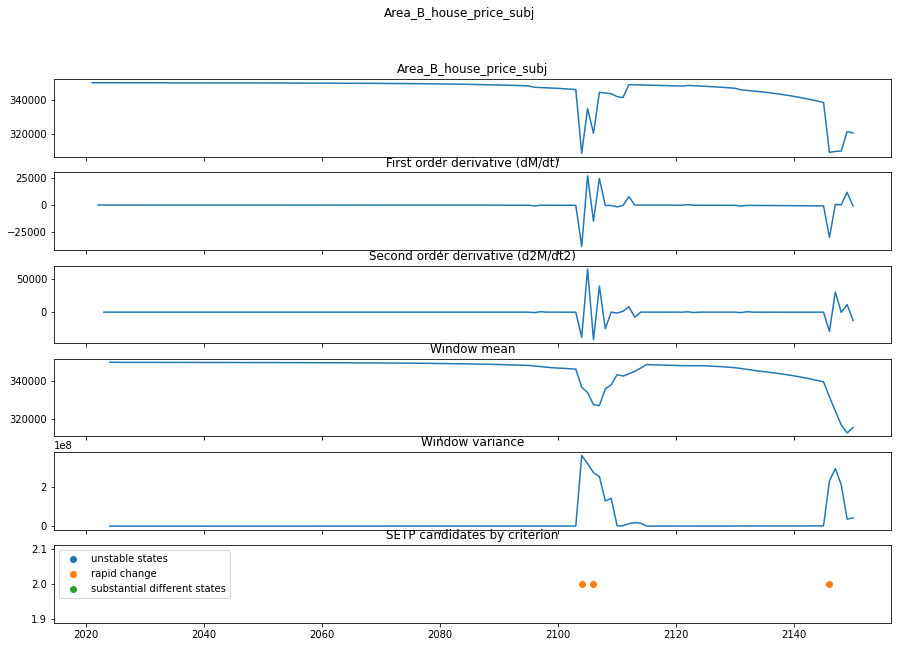

In [44]:
for experiment in experiments:
    print(experiment)
    df = create_df(experiment)
    df[df<0] = 0 #convert all negative values to zero
    
    #Iterate over available performance metrics M
    for M in ['Area_A_house_price_obj', 'Area_A_house_price_subj',
       'Area_B_house_price_obj', 'Area_B_house_price_subj']:
        print(M)
        statistics = examine_series(df[M],domain=(2021,2150))
        #plot_statistics(statistics,figsize=(15,10),save=True,exp_name=experiment.name)
        candidates = select_candidates(statistics,True)
        plot_both(statistics,candidates,figsize=(15,10),save=True,exp_name=experiment.name)